dx= 2  dy= 2 snr= 0.1
feature_selection:  0.59
unsel:  0.0027066308639663523
sel:  0.007304384296916833
elapsed:  2.002516031265259

dx= 2  dy= 2 snr= 0.2
feature_selection:  0.2
unsel:  0.007849133189168784
sel:  0.0561802610927777
elapsed:  2.019768714904785

dx= 2  dy= 2 snr= 0.3
feature_selection:  0.04
unsel:  0.01582442986474757
sel:  0.12880445539763272
elapsed:  2.0171291828155518

dx= 2  dy= 2 snr= 0.4
feature_selection:  0.02
unsel:  0.01814022643774367
sel:  0.2086027617013421
elapsed:  2.03240704536438

dx= 2  dy= 2 snr= 0.5
feature_selection:  0.0
unsel:  0.016276179655429556
sel:  0.3099113748232392
elapsed:  2.0179190635681152

dx= 2  dy= 2 snr= 0.6
feature_selection:  0.0
unsel:  0.018442419077443283
sel:  0.3903024229617405
elapsed:  2.0422868728637695

dx= 2  dy= 2 snr= 0.7
feature_selection:  0.0
unsel:  0.010923578448933248
sel:  0.47277833711189887
elapsed:  2.383894920349121

dx= 2  dy= 2 snr= 0.8
feature_selection:  0.0
unsel:  0.008154122167273892
sel:  0.548462

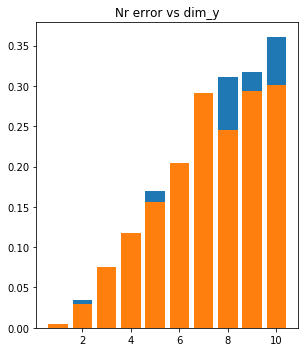

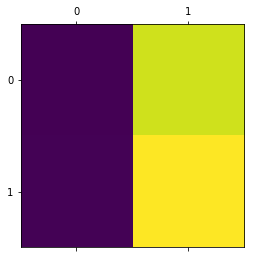

In [836]:
%matplotlib inline
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit

import numpy as np
import itertools
from time import time
from scipy.linalg import sqrtm


def regression(x, y):
    return RidgeCV(fit_intercept=False,alphas=np.logspace(-3,3,10)).fit(x, y)

def bagged_jr(x,y):
    bagging = ShuffleSplit(10, test_size=.5)
    ensemble = [split for split in bagging.split(x, y)]
    H = list()
    for fir, sec in ensemble:
        xhat=regression(y[fir], x[fir]).predict(y[sec])
        H += [regression(x[sec],xhat).coef_, ]
    return np.mean(H, 0)

def sonquist_morgan(x):
    z=np.sort(x)
    n=z.size
    m1=0
    m2=np.sum(z)
    mx=0
    best=-1
    for i in range(n-1): 
        m1+=z[i]
        m2-=z[i]
        ind=(i+1)*(n-i-1)*(m1/(i+1)-m2/(n-i-1))**2
        if ind>mx :
            mx=ind
            best=z[i]
    K=mx/(np.var(x)*n)
    return (x>(best+1.0e-6))


# randn(n,p)/sqrt(min(n,p)) : eigenvalues in the unit circle
def randmat(d_x,d_y):  
    mul=np.sqrt(min(d_x,d_y))
    M=np.random.randn(d_x,d_y)/mul
    return M    
    
# Y = F(MEX+N)  
# X(d_x,n) E(d_x,d_x) M(d_z,d_x) N(d_z,n) F(d_y,d_z) Y(d_y,n)
# [0,n]= training set, [n,4n]: 3 test set, ratio of variance btw training and test (environment) [.5,1,2]
def make_data(n=1000, d_x=100, d_z=100, d_y=50, snr=0.2, nc=2):  
    X=randmat(4*n,d_x)@randmat(d_x,d_x)
    x1=0.5*randmat(n,d_x)@randmat(d_x,d_x)
    x2=1.*randmat(n,d_x)@randmat(d_x,d_x)
    x3=2.*randmat(n,d_x)@randmat(d_x,d_x)
    for i in range(n): 
        X[i+n]=x1[i]
        X[i+2*n]=x2[i]
        X[i+3*n]=x3[i]
    E=np.zeros(d_x)
    E[-nc:]=1.
    E=np.diag(E)    
    M=randmat(d_x,d_z)
    Z = X @ E @ M *snr + randmat(4*n, d_z)
    F = randmat(d_z, d_y)  
    Y = Z @ F 
    return Y, X, E, F



def rolling_covariance(rho, dim):
    cov = np.zeros((dim, dim))
    for i in range(cov.shape[0]):
        for j in range(cov.shape[1]):
            cov[i, j] = np.power(rho, np.abs(i - j) / dim)
    return cov


def synthetic_data_v_1_0(n_samples=1000,   # number of samples
                         dim_x=50,         # number of features
                         rho_x=0.5,        # correlation of features
                         rho_n=0.5,        # correlation of noise
                         dim_y=30,         # number of sensors
                         snr=1.0,          # signal-to-noise ratio
                         nc=5,             # number of selected features
                         nonlinear=False):  # number of selected features
    # linear transformation
    F = np.random.randn(dim_x, dim_y) / np.sqrt(min(dim_x,dim_y))

    # masking transformation
    E = np.array([0] * (dim_x - nc) + [1] * (nc))
    np.random.shuffle(E)
    E = np.diag(E)

    # features
    cov_X = rolling_covariance(rho_x, dim_x)
    X = np.random.randn(n_samples, dim_x) @ sqrtm(cov_X)
    np.random.shuffle(X.T)

    # noise
    cov_N = rolling_covariance(rho_n, dim_x)
    N = np.random.randn(n_samples, dim_x) @ sqrtm(cov_N)
    np.random.shuffle(N.T)

    # observed sensor data
    Y = (snr * X @ E + N) @ F

    if nonlinear:
        Y = 1. / (1. + math.exp(-Y))

    # return inputs, outputs, and solution
    return X, Y, E


n=1000
nc=1
snr=0.8
dx=100
dy=1
v=[]
w=[]
test_regr=False
myniter=100
s0=time()
for dx,dy,sn in itertools.product(range(2,101,100),range(2,101,100),range(1,11,1)):
    snr=sn/10.
    start = time()
    sc_base=0
    sc_sonqfit=0
    sc_average=0
    sc_average2=0
    sc_hat=0
    sc_sonq=0
    sc_oracle=0
    v.append(0)
    w.append(0)
    for iter in range(myniter):
        X, Y, e = synthetic_data_v_1_0(n_samples=n,dim_x=dx,dim_y=dy,snr=snr,nc=nc,rho_x=0.8)
        train=(range(n//2))
        test=(range(n//2,n))
        x=X[train]
        y=Y[train]
        mat_jr = bagged_jr(x, y)
        dia=np.diag(mat_jr)
        sonqsel=sonquist_morgan(dia)
        sc_sonqfit+=np.sum(abs(np.diag(e)-sonqsel))
        sc_average+=(np.sum(dia-np.diag(e)*dia))/nc
        sc_average2+=np.sum(np.diag(e)*dia)/nc
        v[sn-1]+=dia[1]
        w[sn-1]+=dia[0]
        if test_regr:
            base=RidgeCV().fit(x,y)
            hat=RidgeCV().fit(x@np.diag(dia) ,y)
            sonq=RidgeCV().fit(x@np.diag(sonqsel) ,y)
            oracle=RidgeCV().fit(x@df ,y)
            xt=X[test]
            yt=Y[test]
            sc_base+=base.score(xt,yt)
            sc_hat+=hat.score(xt@np.diag(dia) ,yt)
            sc_sonq+=sonq.score(xt@np.diag(sonqsel) ,yt)
            sc_oracle+=oracle.score(xt@df ,yt)

    print("dx=",dx, " dy=",dy, "snr=",snr)
    if test_regr:
        sc_base/=myniter
        sc_hat/=myniter
        sc_sonq/=myniter
        sc_oracle/=myniter
        print("base fit R2: ", sc_base)
        print("e-hat R2: ",sc_hat)
        print("sonquist R2: ",sc_sonq)
        print("oracle R2: ",sc_oracle)
    
    v[sn-1]/=myniter
    w[sn-1]/=myniter
    print("feature_selection: ",sc_sonqfit/myniter)
    print("unsel: ",sc_average/myniter)
    print("sel: ",sc_average2/myniter)
    print("elapsed: ",time()-start)
    print("")

    
print("total=",time()-s0)
print(v)
print(w)
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Nr error vs dim_y")
plt.bar(np.arange(1,11,1), v)
plt.bar(np.arange(1,11,1), w)

#plt.subplot(1, 3, 2)
#plt.title("sonquist selection")
#plt.bar(range(len(sonqsel)),sonqsel)

#plt.subplot(1, 3, 3)
#plt.title("t test selection (95%)")
#plt.bar(range(len(pvalsel)), pvalsel)
#plt.title("sorted JR diagonal")
mj=mat_jr-np.diag(dia)
#plt.bar(range(len(dia)), np.var(mj,1))
plt.tight_layout()
plt.matshow(mat_jr)

    

In [793]:
print(range(1,5,2))


range(1, 5, 2)


In [795]:
print(range(1,5,2))

range(1, 5, 2)


In [774]:
[1,2,3]**2

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

In [777]:
[1,2,3,4,5,6][:-2]

[1, 2, 3, 4]

In [799]:
v=range(1,5)
print(v)

range(1, 5)
